In [15]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly
import warnings
warnings.filterwarnings('ignore')

plotly.offline.init_notebook_mode(connected=True)

In [16]:
# Import DFs we need

# Set folder name
file_path = '../pandas_dfs/'

# Set filenames
merged_data_file = 'merged_data.csv'
final_wars_file = 'final_wars_df.csv'

# Read the files
merged_data = pd.read_csv(file_path + merged_data_file, encoding='latin-1')
final_wars_df = pd.read_csv(file_path + final_wars_file, encoding='latin-1')

In [17]:
# wasn't able to import the function from src.plots, so just copied it in for now

def year_in_war(country_wars, year_row):
    year = year_row['year']
    
    for index, war_row in country_wars.iterrows():
        if war_row['start_year'] <= year <= war_row['end_year']:
            return True
    
    return False

In [18]:
def year_war_name(country_wars, year_row):
    year = year_row['year']
    
    for index, war_row in country_wars.iterrows():
        if war_row['start_year'] <= year <= war_row['end_year']:
            return country_wars.iloc[index, country_wars.columns.get_loc('name')]
    
    return 0

In [19]:
def country_in_war(wars_df, prod_per_year_per_country, country):
    country_wars = (
        wars_df[wars_df['country'].str.contains(country)]
            .groupby(['name', 'start_year', 'end_year'])
            .sum()
            .reset_index()
            .drop('is_state', axis=1)
    )

    country_crops = (
        prod_per_year_per_country[prod_per_year_per_country['country'] == country]
            .drop('country', axis=1)
    )
    
    country_crops['in_war'] = country_crops.apply(lambda row: year_in_war(country_wars, row), axis=1)
    
    country_crops['warName'] = country_crops.apply(lambda row: year_war_name(country_wars, row), axis=1)
    
    return country_crops

In [33]:
merged_data.head()

,country,year,value_crop,value_livestock,value_population,value_land_area
0,Afghanistan,1961-01-01,5909080.0,25104700.0,9169.410,37700.0
1,Afghanistan,1962-01-01,5934534.0,25442170.0,9351.441,37760.0
2,Afghanistan,1963-01-01,5686583.0,25605000.0,9543.205,37810.0
3,Afghanistan,1964-01-01,6147934.0,25855300.0,9744.781,37873.0
4,Afghanistan,1965-01-01,6274668.0,26205500.0,9956.320,37875.0


In [188]:
list_countries = merged_data.country.unique()

In [225]:
list_countries = ['Afghanistan', 'Lebanon', 'Congo', 'Brazil']
list_countries

['Afghanistan', 'Lebanon', 'Congo', 'Brazil']

In [274]:
fig = go.Figure()

for country in list_countries:
    try:
        country_prod_war = country_in_war(final_wars_df, merged_data, country)
        prod_in_war = country_prod_war.copy()
        prod_no_war = country_prod_war.copy()

        prod_in_war['value_crop'][~prod_in_war['in_war']] = None
        prod_no_war['value_crop'][prod_no_war['in_war']] = None



        fig.add_trace(go.Scatter( x=prod_no_war["year"], y=prod_no_war["value_crop"],
                        mode='lines+markers',
                        name='No conflict',
                        hovertext='Not in Conflict',
                        hoverinfo="text",
                        connectgaps=False,
                        visible = False,
                        line=dict(color='RGB(142, 141, 138)', width=2)))


        fig.add_trace(go.Scatter(x=prod_in_war["year"], y=prod_in_war["value_crop"],
                        mode='lines+markers',
                        name='In war',
                        connectgaps=False,
                        hovertext='In war',
                        hoverinfo="text",
                        visible = False,
                        line=dict(color='RGB(232, 90, 79)', width=2)))

        
        fig.update_layout(title='Crop Production',
                           xaxis_title='Year',
                           yaxis_title='Total Production (Tonnes)',
                           plot_bgcolor = "White"
                          )
        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='RGB(234, 231, 220)')
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='RGB(234, 231, 220)')
    except:
        pass

In [275]:
buttons = []

buttons.append(dict(method='update',
                args=[{'visible': [False]*len(list_countries)*2}],
                label='Select Country'))

for i in range(0, len(list_countries)):
    show = [False]*len(list_countries)*2
    show[i*2] = True
    show[i*2+1] = True
    but = dict(method='update',
                args=[{'visible': show}],
                label=list_countries[i])
    buttons.append(but)

In [276]:
menus=list([dict(
            x=0.01,
            y=1,
            yanchor='top',
            xanchor='left',
            buttons= buttons)])

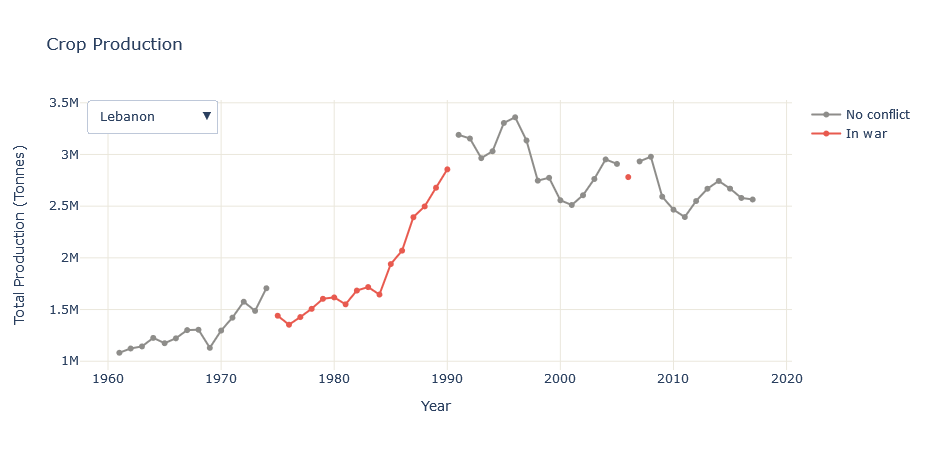

In [277]:
fig.update_layout(updatemenus = menus)                        

In [20]:
country = 'Lebanon'    
country_prod_war = country_in_war(final_wars_df, merged_data, country)

In [21]:
prod_in_war = country_prod_war.copy()
prod_no_war = country_prod_war.copy()


prod_in_war['value_crop'][~prod_in_war['in_war']] = None
prod_no_war['value_crop'][prod_no_war['in_war']] = None

# Get list of unique conflicts for each country
raw_list_conflicts = prod_in_war.warName.unique()
list_conflicts = np.delete(raw_list_conflicts, np.where(raw_list_conflicts == 0))

#prod_in_war.head()

In [22]:
# Make list of dfs

dfs = []

for i in range(len(list_conflicts)):
    dfs.append(prod_in_war.loc[prod_in_war['warName'] == list_conflicts[i]])

In [23]:
# Make list of colors (this will need to be bigger when plotting countries with many wars)

colors_list = ['rgb(220,20,60)', 'rgb(139,0,0)', 'rgb(250,128,114)']

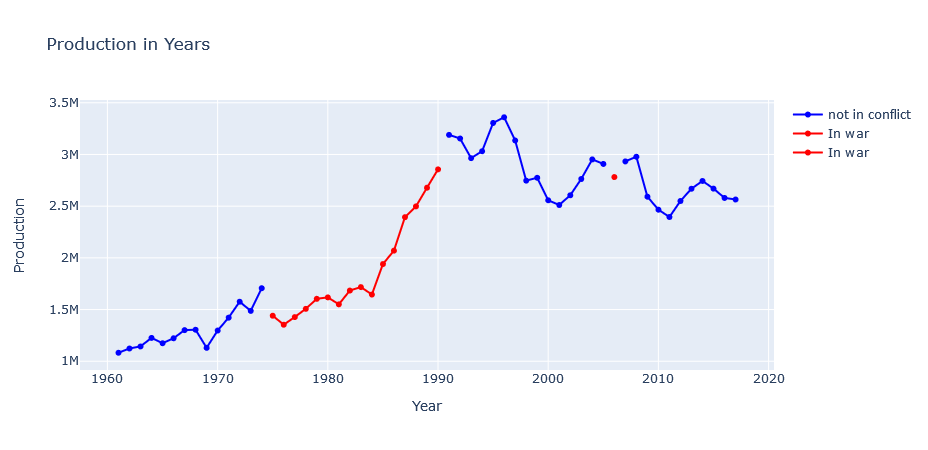

In [29]:
fig = go.Figure()

fig.add_trace(go.Scatter( x=prod_no_war["year"], y=prod_no_war["value_crop"],
                    mode='lines+markers',
                    name='not in conflict',
                    hovertext='Not in Conflict',
                    hoverinfo="text",
                    connectgaps=False,
                    line=dict(color='blue', width=2)))

for i in range(len(list_conflicts)):
    prod_war = dfs[i]
    fig.add_trace(go.Scatter( x=prod_war["year"], y=prod_war["value_crop"],
                    mode='lines+markers',
                    name='In war',
                    connectgaps=False,
                    hovertext='In war',
                    hoverinfo="text",
                    line=dict(color='red', width=2)))


fig.update_layout(title='Production in Years',
                   xaxis_title='Year',
                   yaxis_title='Production',
                  )
              
fig.show()

In [11]:
final_wars_df.head()

,name,country,end_year,is_state,location,participant,start_year
0,Indo-Pakistani War of 1965.,People's Republic of China,1965-01-01,True,Kashmir,India,1965-01-01
1,Indo-Pakistani War of 1965.,People's Republic of China,1965-01-01,True,Kashmir,Pakistan,1965-01-01
2,Indo-Pakistani War of 1965.,Pakistan,1965-01-01,True,Kashmir,India,1965-01-01
3,Indo-Pakistani War of 1965.,Pakistan,1965-01-01,True,Kashmir,Pakistan,1965-01-01
4,Indo-Pakistani War of 1965.,India,1965-01-01,True,Kashmir,India,1965-01-01


In [12]:
import plotly.graph_objects as go
import pandas as pd

In [13]:
# Retrieve geolocations of country centroids

# Set folder name
file_path = '../pandas_dfs/'

# Set filenames
centroids_file = 'country_centroids_df.csv'

# Read the files
country_centroids_df = pd.read_csv(file_path + centroids_file, encoding='latin-1')

In [14]:
# Create df for selected wars
wars_selected = [];
for i in range(len(list_conflicts)):
    wars_selected.append(final_wars_df.loc[final_wars_df['name'] == list_conflicts[i]].reset_index(drop=True))

In [28]:
wars_selected[0]

,name,country,end_year,is_state,location,participant,start_year
0,SovietâAfghan War,Afghanistan,1989-01-01,True,Democratic Republic of Afghanistan,Democratic Republic of Afghanistan,1979-01-01
1,SovietâAfghan War,Afghanistan,1989-01-01,True,Democratic Republic of Afghanistan,Soviet Union,1979-01-01


In [24]:
fig3 = go.Figure()
for j in range(len(list_conflicts)):
    wars_df = wars_selected[j]
    for i in range(len(wars_df)):
        try:
            fig3.add_trace(
                go.Scattergeo(
                    locationmode = 'country names',
                    lon = ([country_centroids_df.loc[country_centroids_df['country'] == wars_df['participant'][i]]['longitude'].values[0], 
                       country_centroids_df.loc[country_centroids_df['country'] == wars_df['country'][i]]['longitude'].values[0]]),
                    lat = ([country_centroids_df.loc[country_centroids_df['country'] == wars_df['participant'][i]]['latitude'].values[0], 
                       country_centroids_df.loc[country_centroids_df['country'] == wars_df['country'][i]]['latitude'].values[0]]),
                    mode = 'lines',  
                    line = dict(width = 2,color =colors_list[j]),
            )
        )
        except:
            pass


Define the menu

In [25]:
buttons = []
for i in range(len(list_conflicts)):
    but = dict(method='restyle',
                args=['visible', [False] * len(list_conflicts)],
                label=list_conflicts[i])
    but['args'][1][i] = True
    buttons.append(but)

In [26]:
menus=list([dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons= buttons)])

In [ ]:
layout = dict(geo=dict(scope='world',
              projection={'type': 'equirectangular'},
              showframe=False),
              margin={"r":0,"t":0,"l":0,"b":0},
              mapbox=dict(zoom = 1.5),
              updatemenus = menus)

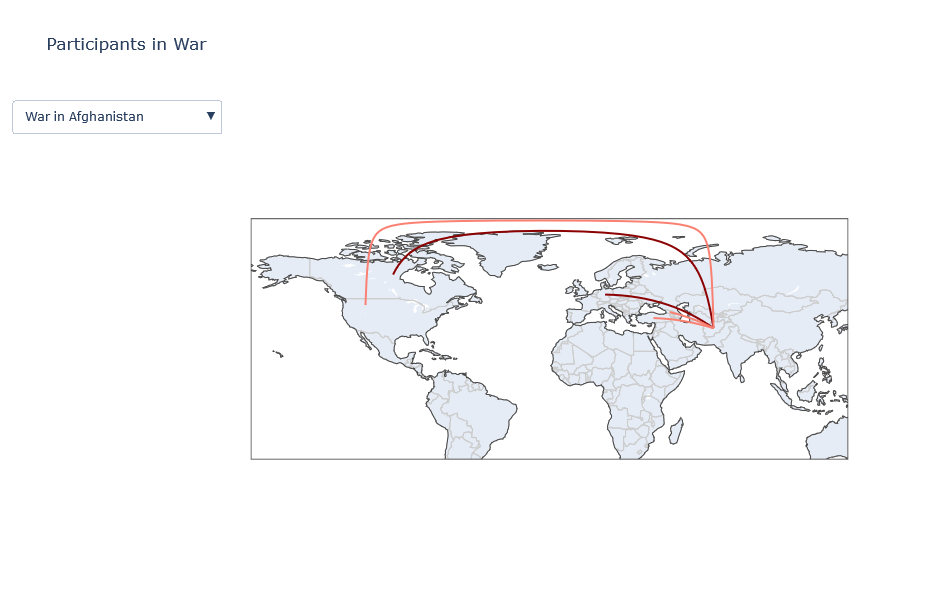

In [27]:
fig3.update_layout(
    title_text = 'Participants in War',
    showlegend = False,
    geo = go.layout.Geo(
        scope = 'world',
        projection_type = 'equirectangular',
        showland = True,
        showcountries = True,
        countrycolor = 'rgb(204, 204, 204)',
    ),
    width=900,
    height=600,
    updatemenus = menus,
)

fig3.show()